In [1]:
# !pip install lazypredict

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

In [3]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, LabelEncoder
from sklearn.metrics import  mean_squared_error, roc_curve, roc_auc_score, fbeta_score, mean_absolute_error, r2_score, make_scorer
from sklearn.linear_model import (Ridge, OrthogonalMatchingPursuit, LinearRegression,
                                  TweedieRegressor, GammaRegressor, Lars, BayesianRidge, RidgeCV, LassoLarsIC)
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import LinearSVR

from lazypredict.Supervised import LazyRegressor

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
df = pd.read_csv('/content/FPT.csv')

## NOTE
Ticker: Mã cổ phiếu.  
Date/Time: Ngày và thời gian giao dịch.  
Open: Giá mở.  
High: Giá cao nhất.  
Low: Giá thấp nhất.  
Close: Giá đóng.  
Volume: Khối lượng giao dịch.   
Open Interest: Số lượng hợp đồng mở.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ticker         97406 non-null  object 
 1   Date/Time      97406 non-null  object 
 2   Open           97406 non-null  float64
 3   High           97406 non-null  float64
 4   Low            97406 non-null  float64
 5   Close          97406 non-null  float64
 6   Volume         97406 non-null  int64  
 7   Open Interest  97406 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 5.9+ MB


In [6]:
df=df.drop(['Ticker', 'Date/Time'],axis=1)

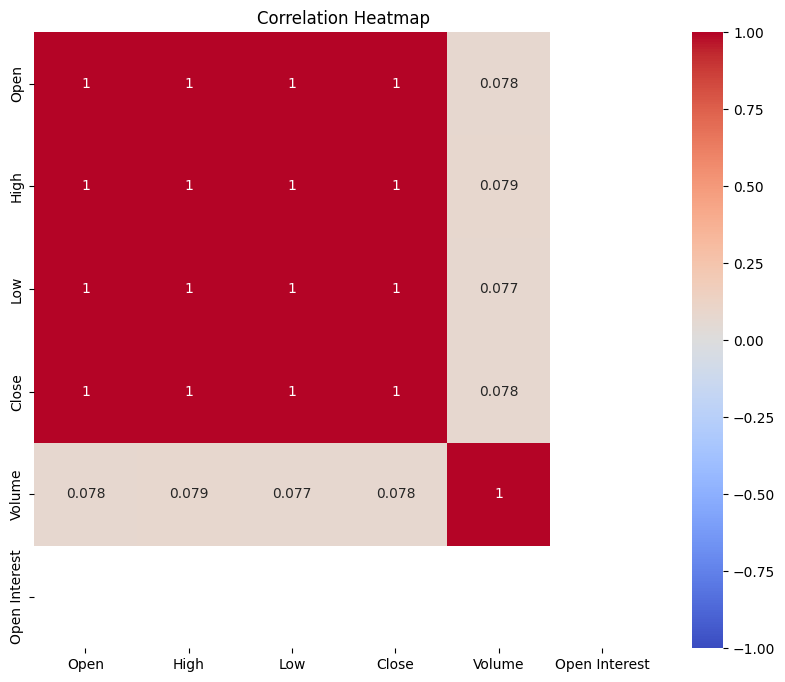

In [7]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [8]:
df=df.drop(['Volume','Open Interest'],axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    97406 non-null  float64
 1   High    97406 non-null  float64
 2   Low     97406 non-null  float64
 3   Close   97406 non-null  float64
dtypes: float64(4)
memory usage: 3.0 MB


In [10]:
def shift_columns(df, target_column, n_shifts):
  """
  Tạo ra tập dữ liệu dự đoán giá (Close) từ dữ liệu từ n (n_shifts) phút trước.

  Parameters:
  df (pd.DataFrame): DataFrame chứa các cột gốc.
  target_column (str): Cột mục tiêu để tạo các cột dịch chuyển thêm một bước so với các cột khác.
  n_shifts (int): Số lượng bước dịch chuyển cho các cột mới.

  Returns:
  pd.DataFrame: DataFrame đã được mở rộng với các cột dịch chuyển.
  """
  df_shifted = df.copy()

  columns = df_shifted.columns.tolist()
  for column in columns:
    if column == target_column:
      for i in range(1, n_shifts + 2):
          df_shifted[f'{column}{i}'] = df_shifted[column].shift(-i)
    else:
      for i in range(1, n_shifts + 1):
          df_shifted[f'{column}{i}'] = df_shifted[column].shift(-i)

  df_shifted = df_shifted.dropna(subset=[f'{columns[0]}{n_shifts}'])

  return df_shifted

n_shifts = 4
target_column = 'Close'
df_ml = shift_columns(df, target_column, n_shifts)

In [11]:
df_ml.head()

,Open,High,Low,Close,Open1,Open2,Open3,Open4,High1,High2,...,High4,Low1,Low2,Low3,Low4,Close1,Close2,Close3,Close4,Close5
0,30.89,30.89,30.89,30.89,30.81,30.74,30.74,30.74,30.81,30.81,...,30.74,30.81,30.74,30.74,30.74,30.81,30.74,30.74,30.74,30.74
1,30.81,30.81,30.81,30.81,30.74,30.74,30.74,30.74,30.81,30.74,...,30.74,30.74,30.74,30.74,30.70,30.74,30.74,30.74,30.74,30.66
2,30.74,30.81,30.74,30.74,30.74,30.74,30.74,30.66,30.74,30.74,...,30.74,30.74,30.74,30.70,30.59,30.74,30.74,30.74,30.66,31.11
3,30.74,30.74,30.74,30.74,30.74,30.74,30.66,31.04,30.74,30.74,...,31.11,30.74,30.70,30.59,31.04,30.74,30.74,30.66,31.11,31.19
4,30.74,30.74,30.74,30.74,30.74,30.66,31.04,31.19,30.74,30.74,...,31.19,30.70,30.59,31.04,31.19,30.74,30.66,31.11,31.19,31.19


In [12]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97402 entries, 0 to 97401
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    97402 non-null  float64
 1   High    97402 non-null  float64
 2   Low     97402 non-null  float64
 3   Close   97402 non-null  float64
 4   Open1   97402 non-null  float64
 5   Open2   97402 non-null  float64
 6   Open3   97402 non-null  float64
 7   Open4   97402 non-null  float64
 8   High1   97402 non-null  float64
 9   High2   97402 non-null  float64
 10  High3   97402 non-null  float64
 11  High4   97402 non-null  float64
 12  Low1    97402 non-null  float64
 13  Low2    97402 non-null  float64
 14  Low3    97402 non-null  float64
 15  Low4    97402 non-null  float64
 16  Close1  97402 non-null  float64
 17  Close2  97402 non-null  float64
 18  Close3  97402 non-null  float64
 19  Close4  97402 non-null  float64
 20  Close5  97401 non-null  float64
dtypes: float64(21)
memory usage: 16.3 MB


## chia train test từ data test và thử trên tất cả model bằng lazypredict

In [13]:
# chỉ lấy 15k row để test do giới hạn Ram
df_test = df_ml.iloc[:15000]

In [14]:
df_test['Close5'].count()

15000

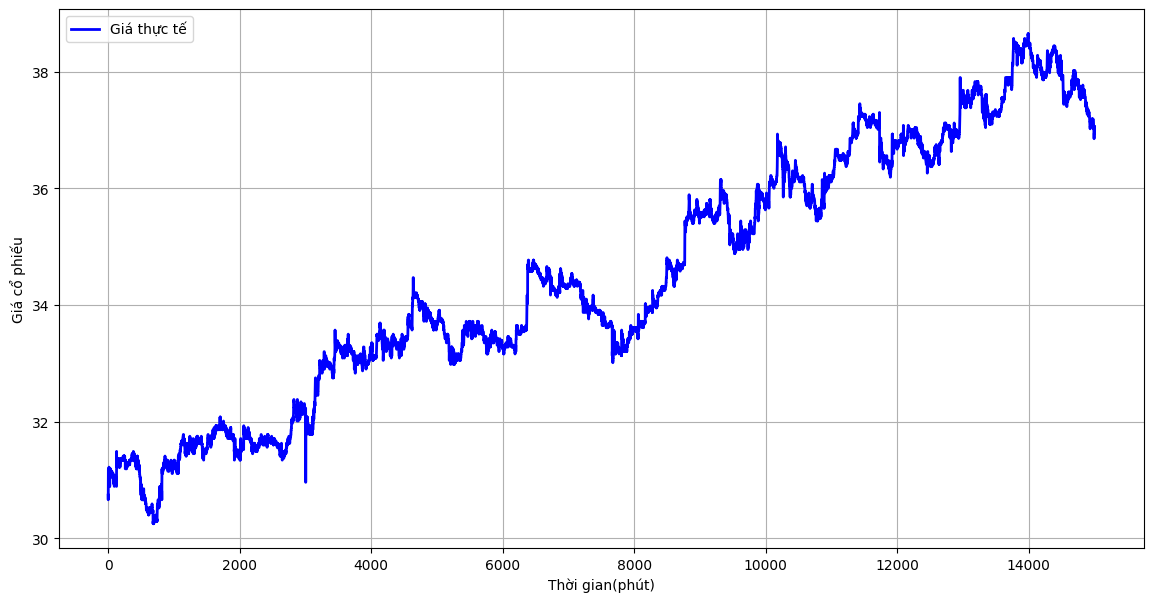

In [15]:
results = pd.DataFrame({
    'Date': df_test.index,
    'Actual': df_test['Close5']
})

results = results.sort_values(by='Date')

plt.figure(figsize=(14, 7))
plt.plot(results['Date'], results['Actual'], label='Giá thực tế', color='blue', linewidth=2)
plt.xlabel('Thời gian(phút)')
plt.ylabel('Giá cổ phiếu')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
X_lazy = df_test.drop(['Close5'],axis=1)
Y_lazy = df_test['Close5']

In [17]:
def train_test_split(X, Y, train_size=0.8):
  """
  Chia dữ liệu thành tập huấn luyện và tập kiểm tra dựa trên tỷ lệ chia train_size và xoá NaN.

  Parameters:
  X (list or np.array or pd.DataFrame): Dữ liệu đầu vào (features) cần chia.
  Y (list or np.array or pd.Series): Dữ liệu mục tiêu (labels) tương ứng với dữ liệu đầu vào.
  train_size (float): Tỷ lệ dữ liệu được sử dụng cho tập huấn luyện. Mặc định là 0.8 (80%).

  Returns:
  x_train_clean (pd.DataFrame or np.array): Tập dữ liệu đầu vào huấn luyện đã được loại bỏ NaN.
  x_test_clean (pd.DataFrame or np.array): Tập dữ liệu đầu vào kiểm tra đã được loại bỏ NaN.
  y_train_clean (pd.Series or np.array): Nhãn tương ứng với tập dữ liệu huấn luyện đã được loại bỏ NaN.
  y_test_clean (pd.Series or np.array): Nhãn tương ứng với tập dữ liệu kiểm tra đã được loại bỏ NaN.
  """
  x_train = X[:int(train_size*len(X))]
  y_train = Y[:int(train_size*len(X))]
  x_test = X[int(train_size*len(X)):]
  y_test = Y[int(train_size*len(X)):]

  train_df = pd.concat([pd.DataFrame(x_train), pd.Series(y_train)], axis=1).dropna()
  x_train_clean = train_df.iloc[:, :-1]
  y_train_clean = train_df.iloc[:, -1]

  test_df = pd.concat([pd.DataFrame(x_test), pd.Series(y_test)], axis=1).dropna()
  x_test_clean = test_df.iloc[:, :-1]
  y_test_clean = test_df.iloc[:, -1]

  return x_train_clean, x_test_clean, y_train_clean, y_test_clean

In [18]:
X_train_lazy, X_test_lazy, y_train_lazy, y_test_lazy = train_test_split(X_lazy, Y_lazy)

In [19]:
lazy_reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=mean_squared_error)

models, predictions = lazy_reg.fit(X_train_lazy, X_test_lazy, y_train_lazy, y_test_lazy)

models

 98%|█████████▊| 41/42 [01:48<00:00,  1.06it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3735
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 20
[LightGBM] [Info] Start training from score 33.747574


100%|██████████| 42/42 [01:48<00:00,  2.59s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken,mean_squared_error
Model,,,,,
LassoLarsCV,0.99,0.99,0.04,0.09,0.00
OrthogonalMatchingPursuitCV,0.99,0.99,0.04,0.04,0.00
LassoLarsIC,0.99,0.99,0.04,0.04,0.00
RidgeCV,0.99,0.99,0.04,0.05,0.00
BayesianRidge,0.99,0.99,0.04,0.14,0.00
Lars,0.99,0.99,0.04,0.03,0.00
LinearRegression,0.99,0.99,0.04,0.02,0.00
TransformedTargetRegressor,0.99,0.99,0.04,0.03,0.00
RANSACRegressor,0.99,0.99,0.04,0.16,0.00


# chọn ra top n model tốt nhất theo số liệu RMSE


In [20]:
filtered_models = models.loc[models['R-Squared'] > 0]

sorted_models = filtered_models.sort_values(by='RMSE' and 'Time Taken')
top_10_models = sorted_models.head(10)

top_10_models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken,mean_squared_error
Model,,,,,
Ridge,0.99,0.99,0.04,0.02,0.00
OrthogonalMatchingPursuit,0.99,0.99,0.04,0.02,0.00
LinearRegression,0.99,0.99,0.04,0.02,0.00
PoissonRegressor,0.91,0.91,0.17,0.03,0.03
Lars,0.99,0.99,0.04,0.03,0.00
TransformedTargetRegressor,0.99,0.99,0.04,0.03,0.00
SGDRegressor,0.99,0.99,0.06,0.03,0.00
PassiveAggressiveRegressor,0.99,0.99,0.04,0.04,0.00
OrthogonalMatchingPursuitCV,0.99,0.99,0.04,0.04,0.00


## chia train test từ data gốc và train trên các model tốt nhất và các thuật toán scaler

In [21]:
X = df_ml.drop(['Close5'],axis=1)
Y = df_ml['Close5']

In [22]:
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X, Y)

In [23]:
regressors = {
    'Ridge': (Ridge(), {'regressor__alpha': [0.1, 1.0, 10.0]}),
    'OrthogonalMatchingPursuit': (OrthogonalMatchingPursuit(), {}),
    'LinearRegression': (LinearRegression(), {}),
    'TransformedTargetRegressor': (TransformedTargetRegressor(regressor=LinearRegression()), {}),
    'GammaRegressor': (GammaRegressor(), {'regressor__alpha': [0.1, 1.0, 10.0]}),
    'Lars': (Lars(), {'regressor__n_nonzero_coefs': [5, 10, 20]}),
    'BayesianRidge': (BayesianRidge(), {'regressor__n_iter': [300, 500, 1000]}),
    'RidgeCV': (RidgeCV(), {'regressor__alphas': [0.1, 1.0, 10.0]}),
    'LassoLarsIC': (LassoLarsIC(), {'regressor__criterion': ['aic', 'bic']}),
    'TweedieRegressor': (TweedieRegressor(), {'regressor__power': [0, 1, 1.5, 2]})
}

scalers={'Standard Scaler' :StandardScaler(),
         'Min Max Scaler':MinMaxScaler(),
         'Roobust Scaler': RobustScaler(),
         'No Scaler': None
        }

tscv = TimeSeriesSplit(n_splits=5)
rmse_scorer = make_scorer(lambda y_true, y_pred: -mean_squared_error(y_true, y_pred, squared=False))  # RMSE scorer

# chọn ra best model và scaler

In [24]:
best_rmse = float('inf')
best_regressor = None
best_scaler = None
best_params = None

for reg_name, (regressor, param_grid) in regressors.items():
    for scaler_name, scaler in scalers.items():
        pipeline_steps = []
        if scaler:
            pipeline_steps.append(('scaler', scaler))
        pipeline_steps.append(('regressor', regressor))
        pipeline = Pipeline(steps=pipeline_steps)

        grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring=rmse_scorer, n_jobs=-1)
        grid_search.fit(X_train_ml, y_train_ml)

        mean_rmse = -grid_search.best_score_
        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_regressor = reg_name
            best_scaler = scaler_name
            best_params = grid_search.best_params_

print("Best model:", best_regressor)
print("Best params:", best_params)
print("Best scaler:", best_scaler)
print("Best mean RMSE:", best_rmse)

Best model: LassoLarsIC
Best params: {'regressor__criterion': 'aic'}
Best scaler: No Scaler
Best mean RMSE: 0.061109229201550576


In [25]:
best_model = regressors[best_regressor][0]
best_scaler_ = scalers[best_scaler]
best_params_ = best_params
best_params_cleaned = {}

for key, value in best_params_.items():
    new_key = key.split('__')[-1]
    best_params_cleaned[new_key] = value

best_pipeline = Pipeline([
    ('scaler', best_scaler_),
    ('classifier', best_model.set_params(**best_params_cleaned))
])
best_pipeline.fit(X_train_ml, y_train_ml)

Pipeline(steps=[('scaler', None), ('classifier', LassoLarsIC())])

In [26]:
y_pred = best_pipeline.predict(X_test_ml)

test_mae = mean_absolute_error(y_test_ml, y_pred)
test_mse = mean_squared_error(y_test_ml, y_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_ml, y_pred)

print("Test MAE is: {:.4f}".format(test_mae))
print("Test MSE is: {:.4f}".format(test_mse))
print("Test RMSE is: {:.4f}".format(test_rmse))
print("Test R^2 Score is: {:.4f}".format(test_r2))

Test MAE is: 0.0436
Test MSE is: 0.0045
Test RMSE is: 0.0674
Test R^2 Score is: 0.9995


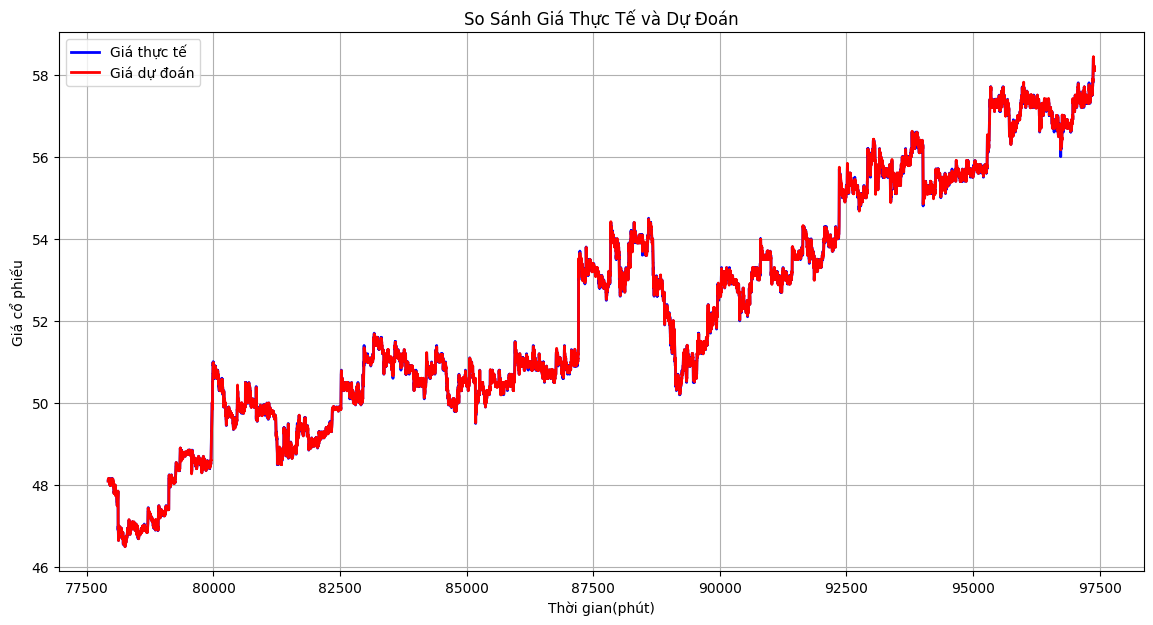

In [27]:
results = pd.DataFrame({
    'Date': X_test_ml.index,
    'Actual': y_test_ml,
    'Predicted': y_pred
})

results = results.sort_values(by='Date')

plt.figure(figsize=(14, 7))
plt.plot(results['Date'], results['Actual'], label='Giá thực tế', color='blue', linewidth=2)
plt.plot(results['Date'], results['Predicted'], label='Giá dự đoán', color='red', linewidth=2)
plt.xlabel('Thời gian(phút)')
plt.ylabel('Giá cổ phiếu')
plt.title('So Sánh Giá Thực Tế và Dự Đoán')
plt.legend()
plt.grid(True)
plt.show()

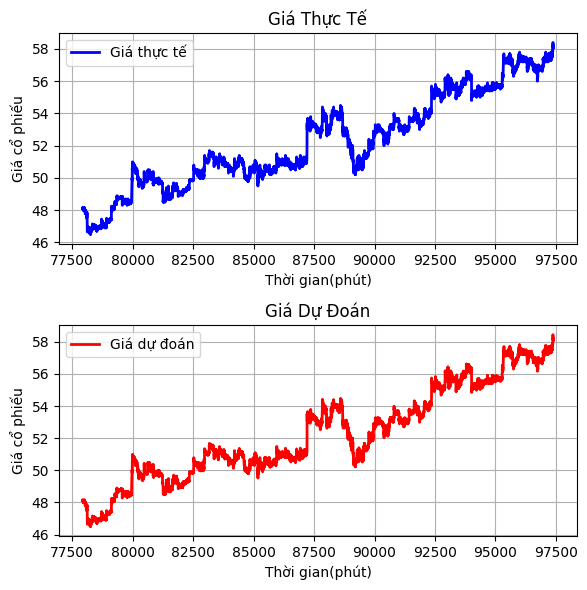

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))

ax1.plot(results['Date'], results['Actual'], label='Giá thực tế', color='blue', linewidth=2)
ax1.set_xlabel('Thời gian(phút)')
ax1.set_ylabel('Giá cổ phiếu')
ax1.set_title('Giá Thực Tế')
ax1.legend()
ax1.grid(True)

ax2.plot(results['Date'], results['Predicted'], label='Giá dự đoán', color='red', linewidth=2)
ax2.set_xlabel('Thời gian(phút)')
ax2.set_ylabel('Giá cổ phiếu')
ax2.set_title('Giá Dự Đoán')
ax2.legend()
ax2.grid(True)

plt.tight_layout()

plt.show()

In [29]:
dump(best_pipeline, 'stock_price_prediction.joblib')

['stock_price_prediction.joblib']

In [30]:
# loaded_pipeline = load('stock_price_prediction.joblib')

In [52]:
single_test = X_test_ml.iloc[3].to_numpy().reshape(1, -1)
y_pred_ml = best_pipeline.predict(single_test)
print(f'giá thực tế',y_test_ml.iloc[3])
print(f'giá dự đoán',y_pred_ml)

giá thực tế 48.15
giá dự đoán [48.14766177]


# sử dụng LSTM

In [32]:
X = df
Y = df['Close']
def create_sequences(X, Y, n_timesteps):
  """
  Tạo các chuỗi thời gian n_timesteps từ dữ liệu đầu vào và nhãn.

  Parameters:
  X (np.array): Dữ liệu đầu vào đã chuyển đổi thành mảng numpy.
  Y (np.array): Nhãn tương ứng với dữ liệu đầu vào.
  n_timesteps (int): Số lượng bước thời gian sử dụng để tạo ra một chuỗi.

  Returns:
  X_seq (np.array): Các chuỗi thời gian tạo ra từ dữ liệu đầu vào.
  Y_seq (np.array): Các nhãn tương ứng với các chuỗi thời gian.
  """
  X_seq, Y_seq = [], []
  for i in range(len(X) - n_timesteps):
      X_seq.append(X[i:i + n_timesteps])
      Y_seq.append(Y[i + n_timesteps])
  return np.array(X_seq), np.array(Y_seq)


In [33]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, Y)

In [34]:
n_timesteps = 5 # 5 timesteps để đồng bộ với dữ liệu cho các model Machine Learning cho việc so sánh kết quả
X_train_lstm, y_train_lstm = create_sequences(X_train_lstm.to_numpy(), y_train_lstm.to_numpy(), n_timesteps)
X_test_lstm, y_test_lstm = create_sequences(X_test_lstm.to_numpy(), y_test_lstm.to_numpy(), n_timesteps)

In [35]:
print(X_train_lstm[1])
print(y_train_lstm[1])

[[30.81 30.81 30.81 30.81]
 [30.74 30.81 30.74 30.74]
 [30.74 30.74 30.74 30.74]
 [30.74 30.74 30.74 30.74]
 [30.74 30.74 30.7  30.74]]
30.66


In [36]:
lstm_model = Sequential()

lstm_model.add(LSTM(units=50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))

lstm_model.add(Dense(units=1))

In [37]:
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')

In [38]:
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=512, validation_data=(X_test_lstm, y_test_lstm))

Epoch 1/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 304.3929 - val_loss: 0.1290
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0150 - val_loss: 0.0239
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0074 - val_loss: 0.0123
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0070 - val_loss: 0.0113
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0073 - val_loss: 0.0134
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0075 - val_loss: 0.0112
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0067 - val_loss: 0.0097
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0079 - val_loss: 0.0090
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0072 - val_loss: 0.0092
Epoch 10/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0072 - val_loss: 0.0091


In [39]:
y_pred_lstm = lstm_model.predict(X_test_lstm)

609/609 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [40]:
test_mae = mean_absolute_error(y_test_lstm, y_pred_lstm)
test_mse = mean_squared_error(y_test_lstm, y_pred_lstm)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_lstm, y_pred_lstm)

print("Test MAE is: {:.4f}".format(test_mae))
print("Test MSE is: {:.4f}".format(test_mse))
print("Test RMSE is: {:.4f}".format(test_rmse))
print("Test R^2 Score is: {:.4f}".format(test_r2))

Test MAE is: 0.0660
Test MSE is: 0.0091
Test RMSE is: 0.0956
Test R^2 Score is: 0.9989


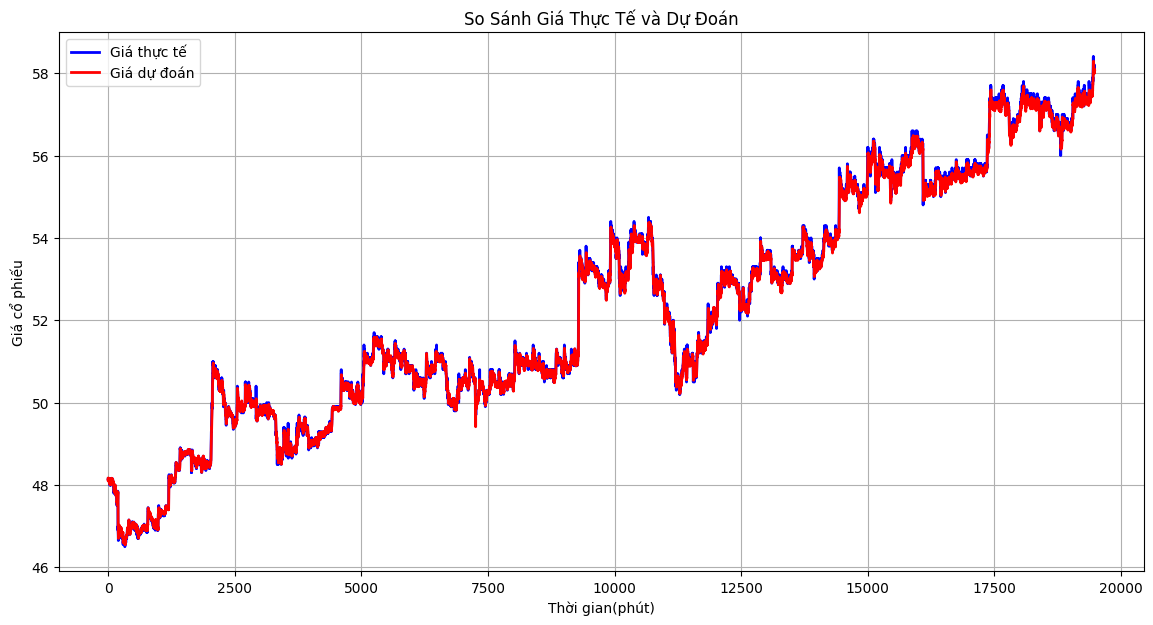

In [41]:
results = pd.DataFrame({
    'Date': np.arange(1, len(X_test_lstm) + 1),
    'Actual': y_test_lstm,
    'Predicted': y_pred_lstm.flatten()

})

results = results.sort_values(by='Date')

plt.figure(figsize=(14, 7))
plt.plot(results['Date'], results['Actual'], label='Giá thực tế', color='blue', linewidth=2)
plt.plot(results['Date'], results['Predicted'], label='Giá dự đoán', color='red', linewidth=2)
plt.xlabel('Thời gian(phút)')
plt.ylabel('Giá cổ phiếu')
plt.title('So Sánh Giá Thực Tế và Dự Đoán')
plt.legend()
plt.grid(True)
plt.show()

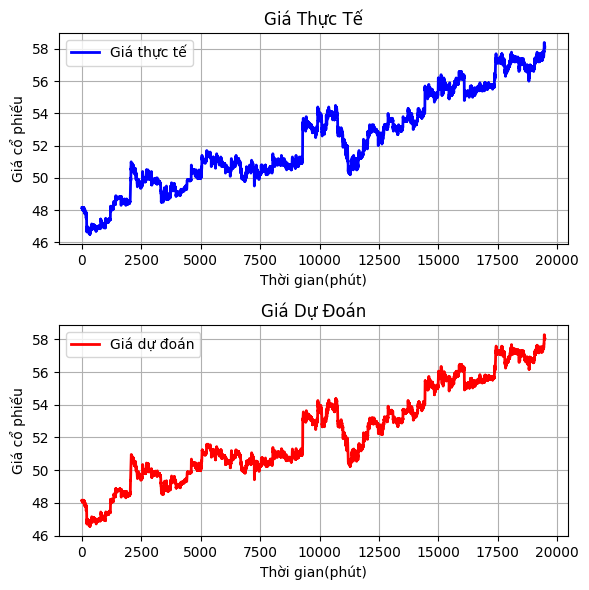

In [42]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))

ax1.plot(results['Date'], results['Actual'], label='Giá thực tế', color='blue', linewidth=2)
ax1.set_xlabel('Thời gian(phút)')
ax1.set_ylabel('Giá cổ phiếu')
ax1.set_title('Giá Thực Tế')
ax1.legend()
ax1.grid(True)

ax2.plot(results['Date'], results['Predicted'], label='Giá dự đoán', color='red', linewidth=2)
ax2.set_xlabel('Thời gian(phút)')
ax2.set_ylabel('Giá cổ phiếu')
ax2.set_title('Giá Dự Đoán')
ax2.legend()
ax2.grid(True)

plt.tight_layout()

plt.show()

In [56]:
single_test = X_test_lstm[3].reshape(1, X_test_lstm.shape[1], X_test_lstm.shape[2])
y_pred_lstm = lstm_model.predict(single_test)
print(f'giá thực tế',y_test_lstm[3])
print(f'giá dự đoán',y_pred_lstm[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
giá thực tế 48.1
giá dự đoán 48.11917


In [47]:
lstm_model.save("LSTM_model.h5")

# Đánh giá mô hình Machine Learning và LSTM

## Kết quả từ mô hình Machine Learning
- Các mô hình Machine Learning tuyến tính như **LassoLarsIC**, **Ridge**, và **OrthogonalMatchingPursuit** đã đạt hiệu suất rất cao với **R²** gần như tuyệt đối (0.99), **RMSE** rất thấp (0.04), và **MAE** cũng rất nhỏ (0.0436).
- **LassoLarsIC** được chọn là mô hình tốt nhất với **RMSE** tốt nhất (0.0611) mà không cần sử dụng scaler.

## Kết quả từ mô hình LSTM
- Mô hình **LSTM** đạt **R²** là 0.9989, cũng rất cao, cho thấy khả năng dự đoán tốt.
- Tuy nhiên, **RMSE** của **LSTM** (0.0956) cao hơn một chút so với các mô hình tuyến tính tốt nhất, cho thấy **LSTM** không thực sự vượt trội so với các mô hình tuyến tính trong bài toán này.
- **MAE** của **LSTM** là 0.0660, cũng lớn hơn so với kết quả từ các mô hình tuyến tính.

## Kết luận
- Các mô hình tuyến tính đơn giản có hiệu suất tốt trong bài toán này với hiệu suất vượt trội và thời gian huấn luyện nhanh hơn.
- **LSTM** mặc dù có thể dự đoán tốt, nhưng không thực sự cần thiết nếu dữ liệu có cấu trúc tuyến tính.
- Đối với những trường hợp tương tự, có thể cân nhắc sử dụng các mô hình tuyến tính như **LassoLarsIC** để đạt được kết quả tốt với chi phí tính toán thấp hơn.
